* https://innovation.alteryx.com/prediction-engineering-churn/
* https://www.kdnuggets.com/2019/05/churn-prediction-machine-learning.html
* https://www.datarobot.com/blog/predicting-churn-how-data-can-help-with-customer-retention/
* https://medium.com/analytics-vidhya/how-to-predict-which-customers-would-churn-based-on-transactional-data-da1c48836e3d

The optional THRESHOLD parameter can be used to modify the default classification threshold of 0.5. For more information on these metrics, you can read through the definitions on precision and recall, accuracy, f1-score, log_loss and roc_auc. Comparing the resulting evaluation metrics can help to decide among multiple models.

Furthermore, we used a confusion matrix to inspect how well the model predicted the labels, compared to the actual labels. The confusion matrix is created using the default threshold of 0.5, which you may want to adjust to optimize for recall, precision, or a balance (more information here).

roc_curve/precision-recall

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from src.config import LABEL_COLUMN
from src.utils import plot_metric_curves
from src.transformer import preprocessor

set_config(display='diagram')   

# Load Dataset

In [2]:
train = pd.read_csv('../data/users_train.csv')
test = pd.read_csv('../data/users_test.csv')

x_train, y_train = train.drop(columns=[LABEL_COLUMN]), train[LABEL_COLUMN]
x_test, y_test = test.drop(columns=[LABEL_COLUMN]), test[LABEL_COLUMN]

# Modeling

## Only numeric features
### Tranformer

### Linear model

In [3]:
linear_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor(categical=False)),
        ("linear_regressor", LogisticRegression(class_weight="balanced")),
    ]
)
linear_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cnt_user_engagement',
                                                   'cnt_level_start_quickplay',
                                                   'cnt_level_end_quickplay',
                                                   'cnt_level_complete_quickplay',
                                                   'cnt_level_reset_quickplay',
                                                   'cnt_post_score',
                                                   'cnt_spend_virtual_currency',
                                                   'cnt_ad_reward',
                                                   'cnt_challenge_a_friend',
                                                   'cnt_completed_5_levels',
                                                   'cnt_use_extra_steps']),
                                                 ('categorical_features',
                                                  'drop',
                                                  ['country_name',
                                                   'device_os']),
                                                 ('ignore_features', 'drop',
                                                  ['user_first_engagement',
                                                   'user_pseudo_id',
                                                   'is_enable', 'bounced',
                                                   'device_lang'])])),
                ('linear_regressor',
                 LogisticRegression(class_weight='balanced'))])

### Evaluation

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       614
           1       0.40      0.41      0.40       185

    accuracy                           0.72       799
   macro avg       0.61      0.61      0.61       799
weighted avg       0.72      0.72      0.72       799



None

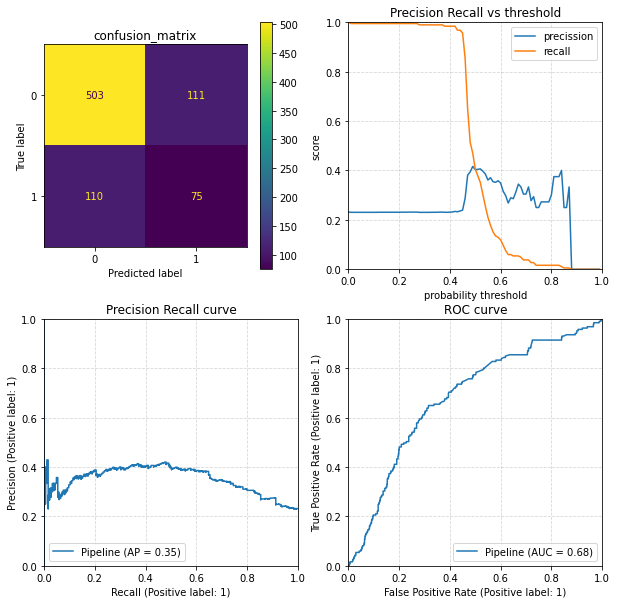

In [4]:
x = x_test
y = y_test

y_pred = linear_model.predict(x)
display(print(metrics.classification_report(y, y_pred)))
ax = plot_metric_curves(linear_model, x, y)

## Numerical and Categorical features

### Modeling

In [14]:
linear_model_full = Pipeline(
    steps=[
        ("preprocessor", preprocessor()),
        ("linear_regressor", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)
linear_model_full.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cnt_user_engagement',
                                                   'cnt_level_start_quickplay',
                                                   'cnt_level_end_quickplay',
                                                   'cnt_level_complete_quickplay',
                                                   'cnt_level_reset_quickplay',
                                                   'cnt_post_score',
                                                   'cnt_sp...
                                                 ('categorical_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_name',
                                                   'device_os']),
                                                 ('ignore_features', 'drop',
                                                  ['user_first_engagement',
                                                   'user_pseudo_id',
                                                   'is_enable', 'bounced',
                                                   'device_lang'])])),
                ('linear_regressor',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

### Evaluation

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       614
           1       0.34      0.46      0.39       185

    accuracy                           0.66       799
   macro avg       0.58      0.59      0.58       799
weighted avg       0.71      0.66      0.68       799



None

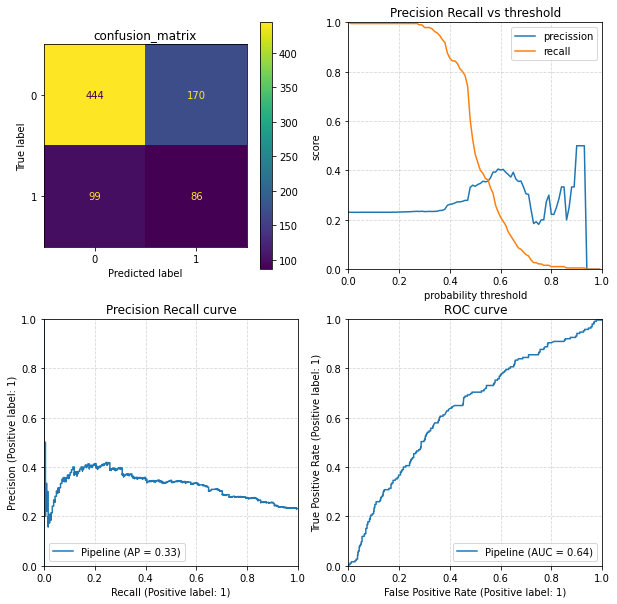

In [15]:
x = x_test
y = y_test

y_pred = linear_model_full.predict(x)
display(print(metrics.classification_report(y, y_pred)))
ax = plot_metric_curves(linear_model_full, x, y)

## Save model 

In [8]:
model_path = 'models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(linear_model, f'{model_path}/linear_model.job')

['models/linear_model.job']